# Experience Analytics

In [1]:
import sys
sys.path.insert(0,'../scripts')

In [2]:
# Setting Notebook preference options, and
# Importing External Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
pd.set_option('max_column', None)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline

In [3]:
# Importing Local Modules
from data_loader import load_df_from_csv
from data_information import DataInfo
from data_cleaner import DataCleaner
from data_manipulation import DataManipulator

## Task 3

We are gonna analyze user experience related to the network parameter performances and the customers’ device characteristics. These are: 
- Average TCP retransmission (by TCP retransmission (Bytes))
- Average RTT (by Avg Delay (ms))
- Handset type (Handset Type)
- Average throughput (Avg Throughput (kbps))

In [4]:
#Fetching and selecting the specified metric columns only
clean_data = load_df_from_csv("../data/teleCo_clean_data.csv")
cleaner = DataCleaner(clean_data)
cleaner.remove_unwanted_columns(cleaner.df.columns[0])
clean_df = cleaner.df

## Task 3.1

### Fixing Outlier Values First

In [5]:
#Apply outlier fixing method if they have outlier values
working_df = cleaner.fix_outlier_columns(['TCP retransmission (Bytes)','Avg Delay (ms)','Avg Throughput (kbps)'])
working_df.loc[:,'Handset Type'].isnull().sum().sum()

0

In [6]:
#aggregating based on MSISDN/Number with the specified metrics and create working Dataframe
aggs_by_col = {'TCP retransmission (Bytes)':'sum', 
               'Avg Delay (ms)':'sum',
               'Avg Throughput (kbps)': 'sum'
               }

working_df = working_df.groupby('MSISDN/Number').agg(aggs_by_col)
rn_df = clean_df.loc[:,['MSISDN/Number','Handset Type']]
rn_df = rn_df.groupby('MSISDN/Number')
working_df['Handset Type'] = rn_df.first().loc[working_df.index.to_list(),['Handset Type']]
working_df

TCP retransmission (Bytes)  Avg Delay (ms)  \
MSISDN/Number                                                    
33601001472.00                      2373938.00           77.00   
33601003520.00                      1186969.00           50.00   
33601007616.00                     11744770.00          203.00   
33601009664.00                      2373938.00           74.00   
33601011712.00                      2484170.00          105.00   
...                                        ...             ...   
33789980672.00                      1197065.00          119.00   
33789997056.00                      1405014.00           92.00   
3197020930048.00                    1186969.00           50.00   
337000045477888.00                  1186969.00           50.00   
882397138649088.00                  1186969.00           50.00   

                    Avg Throughput (kbps)                       Handset Type  
MSISDN/Number                                                                 
33601001472.00                     175.00     Huawei P20 Lite Huawei Nova 3E  
33601003520.00                      97.00        Apple iPhone 7 Plus (A1784)  
33601007616.00                   57092.00            Apple iPhone Se (A1723)  
33601009664.00                    7908.00           Samsung Galaxy A8 (2018)  
33601011712.00                   43760.00  Samsung Galaxy S8 Plus (Sm-G955F)  
...                                   ...                                ...  
33789980672.00                     219.00        Apple iPhone 7 Plus (A1784)  
33789997056.00                   10481.00                Huawei Honor 9 Lite  
3197020930048.00                     1.00   Quectel Wireless. Quectel Ec25-E  
337000045477888.00                  33.00                   Huawei B525S-23A  
882397138649088.00                   2.00   Quectel Wireless. Quectel Ec21-E  

[35090 rows x 4 columns]

## Task 3.2

### Compute & list 10 of the top, bottom and most frequent:

#### Mode for all columns

In [7]:
explorer = DataInfo(working_df)
explorer.get_mode()

TCP retransmission (Bytes)                 1186969.00
Avg Delay (ms)                                  50.00
Avg Throughput (kbps)                           63.00
Handset Type                  Apple iPhone 6S (A1688)
Name: Mode, dtype: object

#### TCP retransmission values in the dataset

In [8]:
explorer.get_min_max_of_column('TCP retransmission (Bytes)',10)

Max Value/s  Min Value/s
0 1425502976.00       134.00
1  133437568.00       176.00
2  101738584.00       177.00
3   98792072.00       179.00
4   97319136.00       211.00
5   86566336.00       232.00
6   76436120.00       369.00
7   76023536.00       430.00
8   75834272.00       490.00
9   75405136.00       515.00

#### RTT values in the dataset

In [9]:
explorer.get_min_max_of_column('Avg Delay (ms)',10)

Max Value/s  Min Value/s
0     85024.00        12.00
1      6053.00        13.00
2      3653.00        14.00
3      3544.00        15.00
4      3525.00        16.00
5      3465.00        17.00
6      3432.00        18.00
7      3078.00        19.00
8      3009.00        20.00
9      2994.00        21.00

#### Throughput values in the dataset

In [10]:
explorer.get_min_max_of_column('Avg Throughput (kbps)',10)

Max Value/s  Min Value/s
0  13805034.00         0.00
1   1293132.00         1.00
2    885926.00         2.00
3    850363.00         3.00
4    810882.00         4.00
5    779183.00         5.00
6    774797.00         6.00
7    765759.00         7.00
8    760574.00         8.00
9    754460.00         9.00

## Task 3.3

### Distribution of Average Throughput and Average of TCP transmission based on Handset Type

#### Distribution of Average Throughput based on Handset Type

In [11]:
#aggregating based on Handset Type with the Avg Throughput (kbps) metric
aggs_by_col = {'Avg Throughput (kbps)': 'sum'}

handset_thr_group_df = working_df.groupby('Handset Type').agg(aggs_by_col)
handset_thr_group_df

Avg Throughput (kbps)
Handset Type                                                             
A-Link Telecom I. Cubot A5                                       23510.00
A-Link Telecom I. Cubot Note Plus                                43770.00
A-Link Telecom I. Cubot Note S                                  102103.00
A-Link Telecom I. Cubot Power                                   138024.00
A-Link Telecom I. Cubot X18 Plus                                  4351.00
...                                                                   ...
Zte Blade V8 Blade V8                                            50950.00
Zte Blade V8 Lite Blade V8 Lite Zte Blade V8 Se                  46834.00
Zte Mf259                                                      2648466.00
Zte Racer Iii Mini Zte Switch X1 Bouygues Telec...              138620.00
Zte Zte Blade C2 Smartphone Android By Sfr Star...                   6.00

[944 rows x 1 columns]

In [12]:
handset_thr_group_df.sort_values('Avg Throughput (kbps)', ascending=False).iloc[:10,:]

Avg Throughput (kbps)
Handset Type                                       
Huawei B528S-23A                       394550464.00
Apple iPhone 6 (A1586)                  77713280.00
Apple iPhone 6S (A1688)                 69822312.00
Apple iPhone 7 (A1778)                  55547988.00
Apple iPhone 8 (A1905)                  46255128.00
Samsung Galaxy S8 (Sm-G950F)            41251400.00
Apple iPhone Se (A1723)                 40630292.00
Huawei E5180                            35366244.00
Apple iPhone Xr (A2105)                 33147048.00
Apple iPhone X (A1901)                  31303050.00

In [13]:
handset_thr_group_df.sort_values('Avg Throughput (kbps)', ascending=False).iloc[-10:,:]

Avg Throughput (kbps)
Handset Type                                                             
Microsoft Mobile. Rm-1116 Microsoft Lumia 950 Xl                    61.00
Samsung Gt-S6790N                                                   51.00
Samsung Gt-S5280                                                    38.00
Htc Desire 10 Lifestyle                                             37.00
Hmd Global Oy Nokia 5 Ss                                            29.00
Lg Lg-D315                                                          21.00
Topwell Technolo. Topwell M318A                                     15.00
Zte Zte Blade C2 Smartphone Android By Sfr Star...                   6.00
Quectel Wireless. Quectel Ec21-E                                     2.00
Quectel Wireless. Quectel Ec25-E                                     1.00

#### Average of TCP transmission based on Handset Type

In [14]:
#aggregating based on Handset Type with the Avg Throughput (kbps) metric
aggs_by_col = {'TCP retransmission (Bytes)': 'sum'}

handset_tcp_group_df = working_df.groupby('Handset Type').agg(aggs_by_col)
handset_tcp_group_df

TCP retransmission (Bytes)
Handset Type                                                                  
A-Link Telecom I. Cubot A5                                          1186969.00
A-Link Telecom I. Cubot Note Plus                                   7467160.00
A-Link Telecom I. Cubot Note S                                      2650418.00
A-Link Telecom I. Cubot Power                                       4755917.00
A-Link Telecom I. Cubot X18 Plus                                    1186969.00
...                                                                        ...
Zte Blade V8 Blade V8                                               1186969.00
Zte Blade V8 Lite Blade V8 Lite Zte Blade V8 Se                     1341550.00
Zte Mf259                                                         442345824.00
Zte Racer Iii Mini Zte Switch X1 Bouygues Telec...                  9349052.00
Zte Zte Blade C2 Smartphone Android By Sfr Star...                  1186969.00

[944 rows x 1 columns]

In [15]:
handset_tcp_group_df.sort_values('TCP retransmission (Bytes)', ascending=False).iloc[:10,:]

TCP retransmission (Bytes)
Handset Type                                            
Huawei B528S-23A                          44372049920.00
Apple iPhone 6 (A1586)                    12581035008.00
Apple iPhone 6S (A1688)                   11944822784.00
Apple iPhone 7 (A1778)                     8686482432.00
Apple iPhone 8 (A1905)                     6964355072.00
Apple iPhone Se (A1723)                    6895015936.00
Samsung Galaxy S8 (Sm-G950F)               5638064640.00
Apple iPhone Xr (A2105)                    5631515648.00
Apple iPhone X (A1901)                     5209937920.00
Huawei E5180                               4469644288.00

In [16]:
handset_tcp_group_df.sort_values('TCP retransmission (Bytes)', ascending=True).iloc[:10,:]

TCP retransmission (Bytes)
Handset Type                                                                  
Gotron (Hk) Elec. Armor X                                              1500.00
Oppo A37F                                                              2377.00
Tinno Mobile Tec. Lt X33                                               5673.00
Tinno Mobile Tec. Tinno S909X S930X S9311 P5003...                     7185.00
Sony Mobile Comm. Sony D2105                                           7232.00
Huawei G8 Huawei Gx8 Huawei G7 Plus                                    7362.00
Acer V370 Acer V370 Liquid E2 Duo                                      8518.00
Lenovo Moto G Plus (4Th Gen) Af12802845                               10227.00
Sony Mobile Comm. Xperia M4 Aqua Dual                                 10293.00
Tcl Communicatio. B-Athena                                            10374.00

## Task 3.4

### k-means clustering of users based on the above metrics

#### k-means clustering to segment users into groups of experiences

In [17]:
### Standardize values before clustering to make it easy for the algorithm

In [18]:
std_df = working_df.copy(deep=True)
dataManipulator = DataManipulator(std_df)
std_df = dataManipulator.standardize_column('Avg Throughput (kbps)')
std_df = dataManipulator.standardize_column('Avg Delay (ms)')
std_df = dataManipulator.standardize_column('TCP retransmission (Bytes)')
std_df = std_df.iloc[:,:-1]
std_df.sample(20)

TCP retransmission (Bytes)  Avg Delay (ms)  \
MSISDN/Number                                                
33665716224.00                        1.34            0.52   
33668583424.00                        1.10            0.72   
33672218624.00                       -0.33           -0.28   
33752629248.00                       -0.42           -0.43   
33661079552.00                        0.46            0.46   
33621331968.00                       -0.33           -0.17   
33624920064.00                       -0.22           -0.22   
33609875456.00                       -0.43           -0.36   
33630441472.00                       -0.43           -0.40   
33695164416.00                       -0.01           -0.04   
33618436096.00                       -0.43           -0.30   
33613023232.00                        0.09           -0.04   
33689372672.00                       -0.43           -0.39   
33614503936.00                       -0.43           -0.39   
33634238464.00                       -0.54           -0.39   
33762093056.00                       -0.22           -0.08   
33610975232.00                       -0.43           -0.42   
33647036416.00                       -0.33           -0.30   
33667606528.00                        2.20            1.53   
33663645696.00                        0.73            0.66   

                Avg Throughput (kbps)  
MSISDN/Number                          
33665716224.00                   0.08  
33668583424.00                   2.02  
33672218624.00                  -0.40  
33752629248.00                  -0.41  
33661079552.00                   0.55  
33621331968.00                  -0.29  
33624920064.00                  -0.28  
33609875456.00                  -0.40  
33630441472.00                  -0.41  
33695164416.00                  -0.30  
33618436096.00                  -0.33  
33613023232.00                  -0.40  
33689372672.00                  -0.41  
33614503936.00                  -0.41  
33634238464.00                  -0.38  
33762093056.00                  -0.35  
33610975232.00                  -0.41  
33647036416.00                  -0.41  
33667606528.00                   1.04  
33663645696.00                   0.89

# Centroids of the clustering:
[[ 0.9174024   0.7982138   0.758616  ]
 [-0.28106567 -0.23934717 -0.25626895]
 [ 2.713973    2.2355988   2.820578  ]]
# The number of iterations required to converge: 64584.5
# The number of iterations required to converge: 18
C:\Python38\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


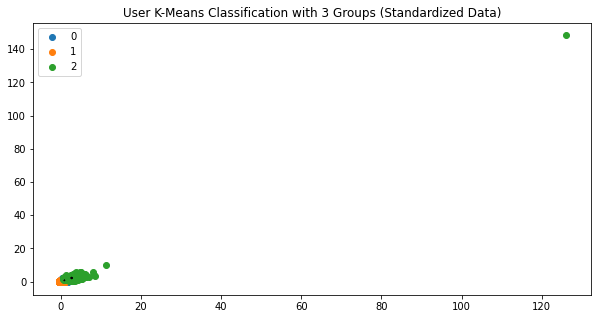

In [19]:
km = KMeans(init="random",n_clusters=3,n_init=10)
label = km.fit_predict(std_df)
centroids = km.cluster_centers_
print(f'# Centroids of the clustering:\n{centroids}')
print(f'# The number of iterations required to converge: {km.inertia_}')
print(f'# The number of iterations required to converge: {km.n_iter_}')

#Getting index based on clusters
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize=(10,5))
plt.title(f'User K-Means Classification with 3 Groups (Standardized Data)')
for i in u_labels:
    plt.scatter(std_df[label == i].iloc[:,0] , std_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

#### Finding the optimimum k-value

In [20]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(std_df)
    sse.append(kmeans.inertia_)

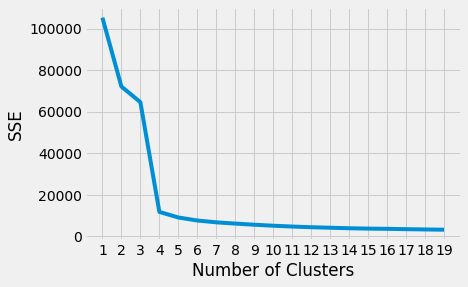

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [22]:
kl = KneeLocator(range(1, 20), sse, curve="convex", direction="decreasing")
kl.elbow

4

# Centroids of the clustering:
[[  2.3974662    1.9539249    2.4360027 ]
 [ -0.2905441   -0.24757953  -0.2639094 ]
 [126.01103    148.39761    129.489     ]
 [  0.8024024    0.7022602    0.6499877 ]]
# The number of iterations required to converge: 11819.3720703125
# The number of iterations required to converge: 56
C:\Python38\lib\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


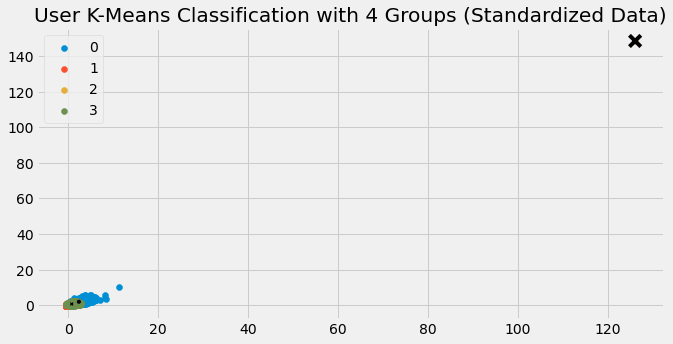

In [24]:
km = KMeans(init="random",n_clusters=kl.elbow,n_init=10)
label = km.fit_predict(std_df)
centroids = km.cluster_centers_
print(f'# Centroids of the clustering:\n{centroids}')
print(f'# The number of iterations required to converge: {km.inertia_}')
print(f'# The number of iterations required to converge: {km.n_iter_}')

#Getting index based on clusters
u_labels = np.unique(label)
 
#plotting the results:
plt.figure(figsize=(10,5))
plt.title(f'User K-Means Classification with {kl.elbow} Groups (Standardized Data)')
for i in u_labels:
    plt.scatter(std_df[label == i].iloc[:,0] , std_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

#### Brief description of each cluster

Users were clustered into 3 distinct clusters. The clusters centroids(grouping points) are [[ 0.8864149,0.77158815,0.7276282]
[ 2.6455426,2.1847298,2.7405233] [-0.28394783,-0.24186659,-0.2586157]].
The clusters describe the classification of users based on the metrics TCP retransmission (Bytes),Avg Delay (ms) and Avg Throughput (kbps). The first cluster with yellow color have all metrics near -0.28+-,0.24+-, the second cluster have all metrics around 0.8 and the third and last cluster have all metrics near 0.8+-,0.7+- and contains an extreme value reaching 120+,140+ value.
The clusters also show as these metrics are inter-related that when there is a high throughput there will be a high delay and retransmision, but when there is a low throughput there will be a low delay and retransmission. And this interprets to the real world as well.

In [26]:
std_df['cluster'] = label
cleaner = DataCleaner(std_df)
cleaner.save_clean_data('../data/experience_cluster.csv')

In [27]:
centroids_df = pd.DataFrame(centroids, columns=['TCP retransmission (Bytes)','Avg Delay (ms)','Avg Throughput (kbps)'])
cleaner = DataCleaner(centroids_df)
cleaner.save_clean_data('../data/experience_centroid.csv')